In [1]:
from google.colab import drive
drive.mount('/drive')

driveDir = "/drive/My Drive/Colab Notebooks/PollenCounter/SimplePollenClassifier/"
driveDir2 = "/drive/My Drive/Colab Notebooks/PollenCounter/SimplePollenClassifier_Video/"
notPollenDir = driveDir + "NotPollen"
pollenDir = driveDir + "Pollen"



weightsDir = driveDir + "weights/"
saved_model_file = weightsDir + "StandardNetwork.h5"

checkpointsDir = driveDir + "checkpoints/"
modelFile = checkpointsDir + "model.150-0.17.hdf5"


testVideo_bad = driveDir2 + "Verticle.MOV"
testVideo_good = driveDir2 + "pollen-video.mp4"

driveDir3 = "/drive/My Drive/PollenImageClassification/"
labelsDir = driveDir3 + "binaryClasses.txt"

weightsDir = driveDir3 + "PvNP_Weights/"
weightsFile = weightsDir + "XceptionBest.h5"

dDir = driveDir3
imgDir = dDir+"MicroscopeImagesandVideos/test.jpg"

#driveDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/USPollenDataset/"
driveDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/PollenVsNotPollen/"


#labelsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/classes.txt"
labelsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/binaryClasses.txt"

dirs = [labelsDir, driveDir]

Mounted at /drive


In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
cwd = os.getcwd()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2842624/45929032 bytes (6.2%)7020544/45929032 bytes (15.3%)11264000/45929032 bytes (24.5%)15474688/45929032 bytes (33.7%)19603456/45929032 bytes (42.7%)23805952/45929032 bytes (51.8%)28073984/45929032 bytes (61.1%)32333824/45929032 bytes (70.4%)36577280/45929032 bytes (79.6%)40787968/45929032 bytes (88.8%)44965888/45929032 bytes (97.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

### Cut up image into smaller peices

In [ ]:
from PIL import Image

def crop(input, height, width):
    arr = [];
    im =  Image.fromarray(input, 'RGB')
    imgwidth, imgheight = im.size
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)
            arr.append(a)
    return arr;

### Load Dataset

In [3]:
def loadDataset(pollenDir="Pollen", notPollenDir="NotPollen"):
    pollenFiles = glob.glob(pollenDir+"/*.jpg")
    notPollenFiles = glob.glob(notPollenDir+"/*.jpg")
    
    X = []
    y = []
    
    for notPollenFile in notPollenFiles:
        img = cv2.imread(notPollenFile)
        X.append(img)
        y.append(0)
    
    for pollenFile in pollenFiles:
        img = cv2.imread(pollenFile)
        X.append(img)
        y.append(1)
    
    X = np.array(X)
    y = np.array(y)
    
    return [X, y]

def loadDataset2(classLabels,imagesDir):
    data = []
    labels = []
    glober = []
    classDict = []
    with open(classLabels,"r") as f:
        for line in f.readlines():
            key = line.strip()
            glober = glob.glob(imagesDir+key+"/*.jpg")
            myClass = np.array(glober)
            classDict.append(key)
            for i in myClass:
                #make sure to map images to brg color values
                #broadcast error because some images will read in (b,g,r,255)
                img = cv2.imread(i, cv2.IMREAD_COLOR) 
                data.append(img)
                labels.append(key)

    return [data,labels]

In [4]:
def addExtraImages():
    # Extra Images
    loc = "../drive/My Drive/USPollenKeras/Images Old/USPollen/"
    classes_file = "../drive/My Drive/USPollen/classes.txt"
    endLoc = "../drive/My Drive/Colab Notebooks/PollenImageClassification/Pollens/"
    
    classes = []
    test = []
    with open(classes_file,"r") as f:
      for line in f.readlines():
        key = line.strip()
        test.append(key)
        glober = glob.glob(loc+"*"+key+"*.jpg")
        classes.append(np.array(glober)) 
    
    counter = 34
    img = cv2.imread(classes[0][0], cv2.IMREAD_UNCHANGED)
    cv2.imwrite(endLoc+"pollen"+repr(counter)+".jpg",img)
    counter = counter+1
    
    counter = 35
    for i in classes:
        for j,val in enumerate(i):
            img = cv2.imread(val, cv2.IMREAD_UNCHANGED)
            if j<4:
                cv2.imwrite(endLoc+"pollen"+repr(counter)+".jpg",img)
                counter = counter+1

### Preprocessing

In [5]:
def resizeDataset(X, width=341, height=512):
    X_new = []
    for a in range(X.shape[0]):
        result = cv2.resize(X[a], (width,height))
        X_new.append(result)
    return np.array(X_new)

### Load PollenNotPollen Classifier

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.applications import VGG16

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [7]:
class PollenCNN(models.Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.data = None
        self.data_train = None
        self.data_test = None
        self.history = None
        
    def buildModel(self, input_shape=(1364, 2048, 3)):
        self.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.add(layers.Flatten())
        self.add(layers.Dense(64, activation='relu'))
        self.add(layers.Dense(2))
        self.summary()
        self.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
    def buildTransferLearnedModel(self,input_shape=(1364, 2048, 3)):
        self.add(tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = input_shape))

        for layer in self.layers[:17]:
            layer.trainable = False

        self.add(layers.Flatten())
        self.add(layers.Dense(256, activation='relu'))
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(4096, activation="relu"))
        self.add(layers.Dense(2, activation="softmax"))
        opt = SGD(lr=0.001, momentum=0.9)
        self.compile(optimizer=opt,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])
        
    def trainModel(self, epochs=10, batch_size=32,augment_batch_size = 8, early_stopping = False, checkpoints = False):
        #Data Augmentation
        aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

        train_generator = aug.flow(self.data_train[0],self.data_train[1],batch_size = augment_batch_size)

        callbacks_arr = []
        if early_stopping:
            callbacks_arr.append(EarlyStopping())
        if checkpoints:
            callbacks_arr.append(ModelCheckpoint(checkpointsDir + "model.{epoch:02d}-{val_loss:.2f}.hdf5", save_freq="epoch"))
            
        self.history = model.fit(train_generator, epochs=epochs, batch_size=batch_size,
                    validation_data=(self.data_test[0], self.data_test[1]),
                    callbacks = callbacks_arr)
        
    def loadData(self, trainDirs=["Pollen", "NotPollen"], trainSubset=None):
        self.data = loadDataset(pollenDir=trainDirs[0], notPollenDir=trainDirs[1])
        
    def preprocess(self, resizeWidth = 341, resizeHeight = 512, testRatio = 0.1):
        # resize data 
        self.data[0] = resizeDataset(self.data[0], width=resizeWidth, height=resizeHeight)
        
        # normalize data between 0 and 1
        self.data[0] = np.array(self.data[0], dtype="float") / 255.0
        
        #Train test split (randomize training/testing, test size set to ratio to training)
        (trainX, testX, trainY, testY) = train_test_split(self.data[0], self.data[1],test_size=testRatio, random_state=42)
        
        self.data_train = [trainX,trainY]
        self.data_test = [testX,testY]
        
    def graphAccuracy(self):
        history = self.history
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')
        
    def getBestEpochByMetric(self,metric = 'val_accuracy', max_or_min = 'max'):
        index = 0
        
        if max_or_min == 'min' :
            for x in range(len(self.history.history[metric])):
                if self.history.history[metric][x] < self.history.history[metric][index] :
                    index = x
        
        if max_or_min == 'max' :
            for x in range(len(self.history.history[metric])):
                if self.history.history[metric][x] > self.history.history[metric][index]:
                    index = x
                    
        return index

    def make_prediction(self,image,class_dictionary):
        #Rescale image
        img = image/255.

        #Convert to a 4D tensor
        image = np.expand_dims(img, axis=0)
        #print(image.shape)

        # make predictions on the preloaded model
        class_predicted = self.predict(image)
        inID = np.argmax(class_predicted[0])
        label = class_dictionary[inID]
        return label


In [8]:
class PollenTypeCNN(models.Model):
    def __init__(self,**kwargs):
        super(PollenTypeCNN,self).__init__(**kwargs)
        self.X = None #Images
        self.labels = None #Labels
        self.OneHotLabels = None #Integer Mapped Labels
        self.data_train = None
        self.data_test = None
        self.history = None
        self.newMod = None
        
    def buildModel(self, input_shape=(1364, 2048, 3)):
        self.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.add(layers.Flatten())
        self.add(layers.Dense(64, activation='relu'))
        self.add(layers.Dense(2,activation='softmax'))
        self.summary()
        self.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    def buildTransferLearnedModel(self,classes = 42,input_shape=(1364, 2048, 3)):
        model = tf.keras.applications.Xception(weights = "imagenet", include_top=False, input_shape = input_shape)

        for layer in model.layers[:-8]:
            layer.trainable = False
        
        x = model.output
        x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        x = Dense(4096, activation="relu")(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.4)(x)
        predictions = Dense(classes, activation="softmax")(x)

        #Functional not Sequential for transfer learned CNN
        self.newMod = Model(model.input,predictions)
        self.newMod.summary()
        self.newMod.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
        
    def loadData(self, trainDirs=["",""]):
        data = loadDataset2(classLabels=trainDirs[0], imagesDir=trainDirs[1])
        self.X = np.array(data[0])
        self.labels = np.array(data[1])
        
    def preprocess(self, resizeWidth = 341, resizeHeight = 512, testRatio = 0.1):
        #
        self.X = resizeDataset(self.X, width=resizeWidth, height=resizeHeight)
        self.X = np.array(self.X, dtype="float") / 255.0

        le = LabelEncoder()

        self.OneHotLabels = le.fit_transform(self.labels)
        y = to_categorical(self.OneHotLabels)
        #Train test split
        (trainX, testX, trainY, testY) = train_test_split(self.X, y,test_size=testRatio, random_state=42)
        self.data_train = [trainX,trainY]
        self.data_test = [testX,testY]

    def trainModel(self, epochs=10, batch_size=32,augment_batch_size = 8):
        #Data Augmentation
        aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

        train_generator = aug.flow(self.data_train[0],self.data_train[1],batch_size = augment_batch_size)
        test_generator = aug.flow(self.data_test[0],self.data_test[1],batch_size = augment_batch_size)

        self.history = model.fit(train_generator, epochs=epochs, batch_size=batch_size,
                    validation_data= test_generator)
        
    def kMeansTrainModel(self, classes = 42,epochs=10, batch_size=32,augment_batch_size = 8,kfolds = 10,weightsName = "VGG16"):
        kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=7)


        #Callbacks
        checkpoint = ModelCheckpoint(weightsName+".h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq='epoch')
        early = EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, mode='auto')

        callbacks = [checkpoint,early]

        for train, test in kfold.split(self.X,self.OneHotLabels):
            #Data Augmentation
            aug = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode="nearest")

            #y vec needs to be 1d vector of all labels initally
            #change to categorical values after the split
            #https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
            cat_trainY = to_categorical(self.OneHotLabels[train], classes)
            cat_testY = to_categorical(self.OneHotLabels[test], classes)

            train_generator = aug.flow(self.X[train],cat_trainY,batch_size = augment_batch_size)
            test_generator = aug.flow(self.X[test],cat_testY,batch_size = 1)

            self.history = self.newMod.fit(train_generator, epochs=epochs, batch_size=batch_size,
                    validation_data= test_generator,callbacks = callbacks)
        
    def graphAccuracy(self):
        history = self.history
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')

    def make_prediction(self,image,class_dictionary):
        #Rescale image
        img = image/255.

        #Convert to a 4D tensor
        image = np.expand_dims(img, axis=0)
        #print(image.shape)

        # make predictions on the preloaded model
        class_predicted = self.newMod.predict(image,batch_size=64,workers=10,use_multiprocessing=True)
        inID = np.argmax(class_predicted)
        label = class_dictionary[inID]
        return label


##Train Model 

In [ ]:
dirs = [labelsDir, driveDir]

#weightsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/TypeWeights/Xception192x192T"
weightsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/PvNP_Weights/Xception192x192"

model = PollenTypeCNN()

#model.buildModel(input_shape=(40, 40, 3))

model.buildTransferLearnedModel(classes = 2,input_shape=(192, 192, 3))

model.loadData(trainDirs=dirs)

model.preprocess(resizeWidth = 192, resizeHeight = 192,testRatio=0.1)

#model.trainModel(epochs=500, batch_size=32,augment_batch_size = 8)

#parameters determined from old classifier
model.kMeansTrainModel(classes = 2,epochs = 12,batch_size = 64,augment_batch_size = 8,kfolds = 10,weightsName=weightsDir )

model.graphAccuracy()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
dic =dict([])

for i,val in enumerate(model.OneHotLabels):
    dic[val] = model.labels[i]

sortedDic = sorted(dic.values(), key=lambda s: s[0])

sortedDic



['Aceracea_Acer_negundo',
 'Asteracea_Xanthium_strumarium',
 'Asteracea_Ambrosia_trifida',
 'Alnus_incana',
 'Artemesia_vulgaris',
 'Ambrosia_psilostachya',
 'Alnus_rubra',
 'Asteracea_Ambrosia_tridentata',
 'Asteracea_Artemesia_pycnocephala',
 'Betula_nigra',
 'Betula_occidentalis',
 'Carya_ovata',
 'Cupressus_arizonica',
 'Chenopodium_album',
 'Casuarina_equisetifolia',
 'Fraxinus_americana',
 'Fagus_grandifolia',
 'Juniperus_virginiana',
 'Juniperus_scopulorum',
 'Juglandacea_Carya_alba',
 'Juniperus_asheii',
 'Juglandacea_Carya_laciniosa',
 'Juglans_californica',
 'Melaleuca_quinquenervia',
 'Moracea_Morus_rubra',
 'Non_pollen',
 'Olea_europeae',
 'Plantango_lanceolata',
 'Poaceae_Dactylis_glomerata',
 'Pinacea_Pinus_strobus',
 'Platanacea_Platanus_sp.',
 'Quercus_agrifolia',
 'Quercus_nigra',
 'Rumex_crispus',
 'Salix_lasiolepsis',
 'Salix_nigra',
 'Soldiago_sp.',
 'Saliceae_Populus_sp.',
 'Salsola_kali',
 'Ulmus_americana',
 'Ulmaceae_celtis_occidentalis',
 'Urtica_dioica',
 'pla

In [ ]:
def loadCustomModel(file):
    return load_model(file, custom_objects = {"PollenCNN" : PollenCNN})

In [ ]:
# loaded_model = loadCustomModel(modelFile)
loaded_model = PollenTypeCNN()
loaded_model.buildTransferLearnedModel(classes = 2,input_shape=(192, 192, 3))

weightsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/PvNP_Weights/"
weightsFile = weightsDir + "Xception192x192.h5"

loaded_model.newMod.load_weights(weightsFile)

83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
_____________________________

In [ ]:
type_model = PollenTypeCNN()
type_model.buildTransferLearnedModel(classes = 43,input_shape=(192, 192, 3))

weightsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/TypeWeights/"
weightsFile = weightsDir + "Xception192x192T.h5"

type_model.newMod.load_weights(weightsFile)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
type_model

##Image Preprocessing

In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist 

In [ ]:
class PollenPreprocessing():
    def __init__(self):
        self.image = None
        self.mask = None
        self.centers = None
    

    def readImg(self,dir):
        startImg = cv2.imread(dir)
        self.image = np.array(startImg)
        return self.image

    def showImg(self,image):
        imgCopy = image
        plt.imshow(imgCopy)
        plt.show()

    def resizeImg(self,image,ratio=4):
        l = image.shape[0]
        w = image.shape[1]
        return cv2.resize(image,(l*ratio,l*ratio),interpolation = cv2.INTER_CUBIC)

    def getRects(self,image,size = (64,64)):
        newImg = copy.copy(image)
        length = newImg.shape[0]
        width = newImg.shape[1]
        rects = []
        x1 = 0
        y1 = 0
        #Top down 
        while y1 + size[1] < length:
            while x1 + size[0] < width:
                x2 = x1+size[0]
                y2 = y1+size[1]
                rects.append(newImg[y1:y2,x1:x2].copy())
                x1 = x2
            y1 = y2
            x1 = 0

        return np.array(rects)

    def reduceBackgroundNoise(self,img,lowThresh=35,highThresh=130,smallestArea = 75,largestArea = 10000):
        #Convert to grey Img and make histograms based on color
        greyImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        filtdat  =  ndimage.median_filter ( greyImg,size = 15)
        hi_dat = np.histogram(img ,bins = np.arange( 256 ))
        hi_filtdat = np.histogram(filtdat ,bins = np.arange( 256 ))

        #Color thresholds from median_filter
        void = filtdat <= lowThresh
        pollen = np.logical_and(filtdat > lowThresh,filtdat<highThresh)
        over = filtdat > highThresh
        #Hot encode thresholds
        phases  =  void . astype ( np . int )  +  2 * pollen . astype ( np . int )  +  3 * over . astype ( np . int )

        #Create mask for just values in pollen range
        pollen_op  =  ndimage . binary_opening ( pollen ,  iterations = 2 )
        pollen_labels ,  pollen_nb  =  ndimage . label ( pollen_op )
        pollen_areas = np . array ( ndimage . sum ( pollen_op , pollen_labels , np . arange ( pollen_labels . max () + .1 ))) 
        mask = np.logical_or(pollen_areas < smallestArea,pollen_areas>largestArea)
        remove_non_pollen = mask [ pollen_labels.ravel()] . reshape ( pollen_labels . shape )

        #replace all non pollen with background color (most common pixel value)
        img_temp = copy.copy(img)
        unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
        img_temp[remove_non_pollen] = unique[np.argmax(counts)]
        return img_temp

    #Run for optimal k value
    def kMeansElbowTest(self,maxK,HSV = True):
        if self.image.any() != None:
            if HSV:
                img = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                img=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)

            vectorized = img.reshape((-1,3))
            vectorized = np.float32(vectorized)

            #the below line of code defines the criteria for the algorithm to stop running,  
            #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)  
            #becomes 85% 
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
            distortions = [] 

            K = range(1,maxK)
              
            for k in K: 
                # then perform k-means clustering wit h number of clusters defined as 3 
                #also random centres are initally chosed for k-means clustering 
                retval, labels, self.centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)     
                distortions.append(sum(np.min(cdist(vectorized, self.centers,'euclidean'),axis=1)) / vectorized.shape[0]) 
                

            plt.plot(K, distortions, 'bx-') 
            plt.xlabel('Values of K') 
            plt.ylabel('Distortion') 
            plt.title('The Elbow Method using Distortion') 
            plt.show() 
        else:
            print("No Image Loaded")

    def kMeans(self,k,HSV = True):
        if self.image.any() != None:
            if HSV:
                img = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                img=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)

            vectorized = img.reshape((-1,3))
            vectorized = np.float32(vectorized)

            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
            # then perform k-means clustering wit h number of clusters defined as 3 
            #also random centres are initally chosed for k-means clustering 
            retval, labels, self.centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            # convert data into 8-bit values 
            self.centers = np.uint8(self.centers) 
            segmented_data = self.centers[labels.flatten()] 
              
            # reshape data into the original image dimensions 
            self.mask = segmented_data.reshape((self.image.shape)) 

            #Plot result during testing phase
            plt.imshow(self.mask)
            plt.title('Final'), plt.xticks([]), plt.yticks([])
            plt.show()
        else:
             print("No Image Loaded")

        
    def threshold(self,low,high,HSV = True):
        if self.image.any() != None:
            if HSV:
                self.image = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                self.image=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)
        
            # Define lower and uppper limits of what we call "brown"
            brown_lo=np.array(low)
            brown_hi=np.array(high)

            # Mask image to only select browns
            mask=cv2.inRange(self.image,brown_lo,brown_hi)
            self.image[mask>0] = self.centers[-1] #last in center array is largest group in kmeans ... background color

            #Convert back to BGR 
            if HSV:
                self.image = cv2.cvtColor(self.image,cv2.COLOR_HSV2BGR)
            else:
                self.image=cv2.cvtColor(self.image,cv2.COLOR_RGB2BGR)

            plt.imshow(self.image)
            plt.show()
        else:
            print("No Image Loaded")
        





    

##[Find Bubbles and grains](https://yiyibooks.cn/sorakunnn/Scipy%E8%AE%B2%E4%B9%89/scipy-lecture-notes/intro/summary-exercises/answers_image_processing.html)



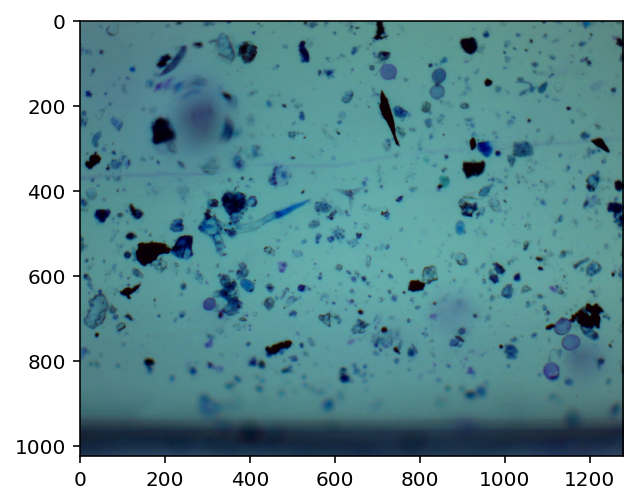

In [ ]:
import pylab as pl 
from scipy import ndimage
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

dDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/"
imgDir = dDir+"MicroscopeImagesandVideos/test2.jpg"

poll = PollenPreprocessing()
img = poll.readImg(imgDir)

#img = poll.resizeImg(img,4)

plt.imshow(img)
plt.show()

newImg = poll.reduceBackgroundNoise(img,lowThresh=35,highThresh=120,smallestArea = 100,largestArea = 10000)
plt.imshow(newImg)
plt.show()


hsv = cv2.cvtColor(newImg, cv2.COLOR_BGR2HSV)

im2 = newImg.copy()

#--- find circles in the hue channel ---
circles = cv2.HoughCircles(hsv[:,:,0],cv2.HOUGH_GRADIENT, 1, 75, param1=15, param2=30, minRadius=0,maxRadius=400)
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(im2,(i[0],i[1]),i[2],(0,255,0),2)

        # draw the center of the circle
        cv2.circle(im2,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(im2)
plt.show()









In [ ]:
h = 192
w = 192

# convert the image to grayscale
gray_image = cv2.cvtColor(newImg, cv2.COLOR_BGR2GRAY)

# convert the grayscale image to binary image
ret,thresh = cv2.threshold(gray_image,127,255,0)

# find contours in the binary image
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)
    try:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(newImg, (cX, cY), 5, (255, 255, 255), -1)

        left = int(cX-w/2)
        right = int(cX+w/2)
        if left < 0:
            right = left*-1+right
            left = 0
        top = int(cY-h/2)
        bot = int(cY+h/2)
        if top < 0:
            bot = top*-1+bot
            top = 0
        crop_img = img[top:bot,left:right]

        plt.imshow(crop_img)
        plt.show()


        # calculate x,y coordinate of center
        #if int(M["m10"] / M["m00"]) != 0 and int(M["m01"] / M["m00"]) != 0:

    except ZeroDivisionError:
        print()

plt.imshow(newImg)
plt.show()

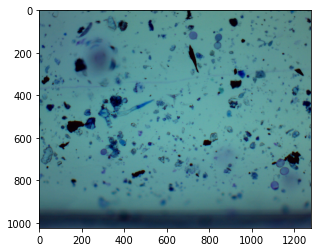

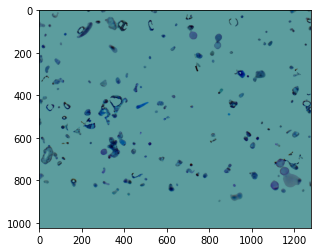

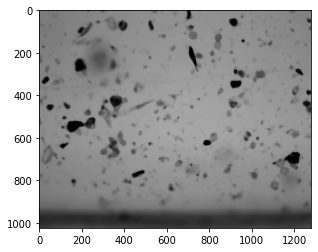

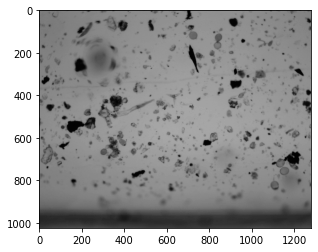

In [ ]:
dDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/"
imgDir = dDir+"MicroscopeImagesandVideos/test2.jpg"

poll = PollenPreprocessing()
img = poll.readImg(imgDir)

plt.imshow(img)
plt.show()

plt.imshow(poll.reduceBackgroundNoise(img))
plt.show()


greyImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

filtdat  =  ndimage.median_filter ( greyImg,size = 15)
hi_dat = np.histogram(img ,bins = np.arange( 256 ))
hi_filtdat = np.histogram(filtdat ,bins = np.arange( 256 ))

#poll.showImg(img)
plt.imshow(filtdat, cmap="gray", vmin=0, vmax=255)
plt.show()



plt.imshow(greyImg, cmap="gray", vmin=0, vmax=255)
plt.show()



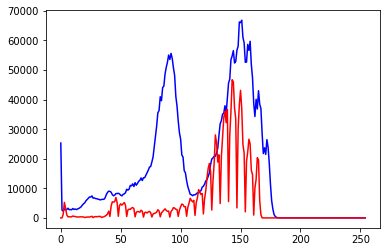

In [ ]:
plt.plot(hi_dat[1][:-1],hi_dat[0],color = 'blue')
plt.plot(hi_filtdat[1][:-1],hi_filtdat[0],color = 'red')
plt.show()

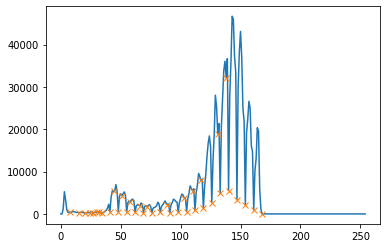

In [ ]:
from scipy.signal import argrelextrema

from scipy.signal import find_peaks
localMinIndexs = argrelextrema(hi_filtdat[0], np.less)

x = hi_filtdat[0]
vals = x[localMinIndexs]

plt.plot(x)
plt.plot(np.reshape(localMinIndexs,(len(localMinIndexs[0]),)), vals, "x")

void = filtdat <= 35
pollen = np.logical_and(filtdat > 35,filtdat<120)
over = filtdat > 120


In [ ]:
phases  =  void . astype ( np . int )  +  2 * pollen . astype ( np . int )  +  3 * over . astype ( np . int )

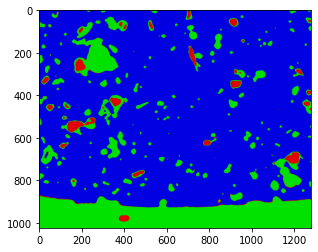

In [ ]:
copyImg = copy.copy(img)

copyImg[phases>2]=[0,0,225]
copyImg[phases<2] = [225,0,0]
for i,val in enumerate(phases):
    for j,val2 in enumerate(val):
        if val2 == 2:
            copyImg[i][j]  = [0,225,0]
plt.imshow(copyImg)
plt.show()

In [ ]:
pollen_op  =  ndimage . binary_opening ( pollen ,  iterations = 2 )
pollen_labels ,  pollen_nb  =  ndimage . label ( pollen_op )
pollen_areas = np . array ( ndimage . sum ( pollen_op , pollen_labels , np . arange ( pollen_labels . max () + .1 ))) 
mask = np.logical_or(pollen_areas < 75,pollen_areas>10000)
remove_non_pollen = mask [ pollen_labels.ravel()] . reshape ( pollen_labels . shape )

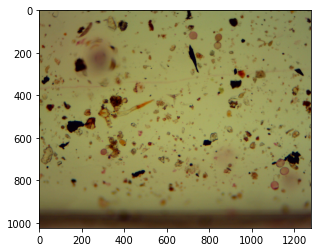

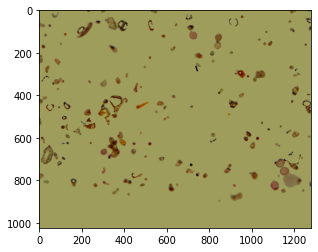

In [ ]:
img_temp = copy.copy(img)
unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
img_temp[remove_non_pollen] = unique[np.argmax(counts)]



plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_temp,cv2.COLOR_BGR2RGB))

#plt.imshow(remove_non_pollen,cmap='gray')
plt.show()




### Video Code

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from multiprocessing.pool import ThreadPool
from collections import deque



In [ ]:
video_name = testVideo_good
video_name = "../drive/My Drive/Colab Notebooks/PollenImageClassification/2020-09-15 100x Video scan 1.mp4"
cap = cv2.VideoCapture(video_name)
ret = True
count = 0
video_obj = None

poll = PollenPreprocessing()

pollenInd = []

typeDict = ['Aceracea_Acer_negundo',
 'Asteracea_Xanthium_strumarium',
 'Asteracea_Ambrosia_trifida',
 'Alnus_incana',
 'Artemesia_vulgaris',
 'Ambrosia_psilostachya',
 'Alnus_rubra',
 'Asteracea_Ambrosia_tridentata',
 'Asteracea_Artemesia_pycnocephala',
 'Betula_nigra',
 'Betula_occidentalis',
 'Carya_ovata',
 'Cupressus_arizonica',
 'Chenopodium_album',
 'Casuarina_equisetifolia',
 'Fraxinus_americana',
 'Fagus_grandifolia',
 'Juniperus_virginiana',
 'Juniperus_scopulorum',
 'Juglandacea_Carya_alba',
 'Juniperus_asheii',
 'Juglandacea_Carya_laciniosa',
 'Juglans_californica',
 'Melaleuca_quinquenervia',
 'Moracea_Morus_rubra',
 'Non_pollen',
 'Olea_europeae',
 'Plantango_lanceolata',
 'Poaceae_Dactylis_glomerata',
 'Pinacea_Pinus_strobus',
 'Platanacea_Platanus_sp.',
 'Quercus_agrifolia',
 'Quercus_nigra',
 'Rumex_crispus',
 'Salix_lasiolepsis',
 'Salix_nigra',
 'Soldiago_sp.',
 'Saliceae_Populus_sp.',
 'Salsola_kali',
 'Ulmus_americana',
 'Ulmaceae_celtis_occidentalis',
 'Urtica_dioica',
 'platanus_racemosa']
  
            
            for img in poll.getRects(image,size=(192,192)):
              label = loaded_model.make_prediction(np.array(img), ['Is Not Pollen', 'Is Pollen'])
              if label == "Is Pollen" :
                  #Pollen Type Classifier Predict goes here
                  label2 = type_model.make_prediction(np.array(img), typeDict)
                  #Showing all the pollen
                  pollenInd.append(img)
                  b,g,r = cv2.split(img)           # get b, g, r
                  img = cv2.merge([r,g,b])
                  plt.imshow(img)
                  plt.show()
                  print(label2)

                  if label2 != 'Non_pollen':
                      is_pollen += 1
                  else :
                      isnt_pollen +=1
              else :
                  isnt_pollen += 1



In [ ]:
video_name = testVideo_good
video_name = "../drive/My Drive/Colab Notebooks/PollenImageClassification/2020-09-15 100x VIdeo scan 2.mp4"
cap = cv2.VideoCapture(video_name)
ret = True
count = 0
video_obj = None

poll = PollenPreprocessing()

pollenInd = []

imOutCount = 0
    
while ret:
        ret, image = cap.read()
        count += 1
        if count == 50:
            count = 0
            
            # image = cv2.resize(image,(1280,720),fx=0,fy=0, interpolation = cv2.INTER_CUBIC) #resize
            ### resize data charlie ###
            
            image = poll.resizeImg(image,3)
            image = poll.reduceBackgroundNoise(image,)
            ###
            

            new_image = np.copy(image)
            overlay = np.copy(image)
            is_pollen = 0
            isnt_pollen = 0
            color = [0, 255, 0] 
            alpha=0.5
            
            for img in poll.getRects(image,size=(192,192)):
              label = loaded_model.make_prediction(np.array(img), ['Is Not Pollen', 'Is Pollen'])
              if label == "Is Pollen" :
                #Pollen Type Classifier Predict goes here

                #Showing all the pollen
                pollenInd.append(img)


                #out = "../drive/My Drive/Colab Notebooks/PollenImageClassification/MicroscopeImagesandVideos/Out/"
                #imOutCount += 1
                #cv2.imwrite(out+"outPvNP915_2"+repr(imOutCount)+".jpg",img)

                b,g,r = cv2.split(img)           # get b, g, r
                img = cv2.merge([r,g,b])
                plt.imshow(img)
                plt.show()


                is_pollen += 1
              else :
                isnt_pollen += 1
            
          #   for spot in final_spot_dict.keys():
          #       all_spots += 1
          #       (x1, y1, x2, y2) = spot
          #       (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
          #       #crop this image
          #       spot_img = image[y1:y2, x1:x2]
          #       #plt.imshow(spot_img)
          #       #plt.show()
          #  # print('Before resize: ', spot_img.shape)
          #       spot_img = cv2.resize(spot_img, (48, 48))
          #   #print('After resize: ', spot_img.shape)
        
          #       label = make_prediction(spot_img)
          #       #print(label)
          #       if label == 'empty':
          #           cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
          #           cnt_empty += 1
            
            
            newImg = cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)
            
            newImg = cv2.putText(new_image, "Is Pollen: %d" %is_pollen, (30, 95), cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)

            print("Is Pollen: "+repr(is_pollen))
    
            newImg = cv2.putText(new_image, "Is Not Pollen: %d" %isnt_pollen, (30, 125), cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)

            print("Is Not Pollen: "+repr(isnt_pollen))

            # cv2.imshow('frame', new_image)
            #cv2_imshow(new_image)
            b,g,r = cv2.split(new_image)           # get b, g, r
            img = cv2.merge([r,g,b])
            plt.imshow(img)
            plt.show()



                
        #out.write(image)

cv2.destroyAllWindows()
cap.release()

